## Table of Contents:  <a class="anchor" id="contents"></a>
* [Imports](#Imports)
* [Processing and Importing Dataframes](#processing)
* [Correlations and Accuracy](#correlations)
* [10%](#10)
* [20%](#20)
* [50%](#50)

## Imports <a class="anchor" id="Imports"></a>
[ToC](#contents)

In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from   IPython.core.display import HTML
import numpy as np
from   datetime import datetime, timedelta
from   pandas.tseries.offsets import *

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Processing and Importing Dataframes  <a class="anchor" id="processing"></a>
[ToC](#contents)

In [3]:
# Read in Dataframes
dfReuters = pd.read_csv(r'/Users/maya/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/New Merged Sentiment Reuters.csv')
dfMW = pd.read_csv(r'/Users/maya/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/New Merged Sentiment MW.csv')
dfTMF = pd.read_csv(r'/Users/maya/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/New Merged Sentiment TMF.csv')

dfsentimentFrames = [dfReuters, dfMW, dfTMF]
dfsentiment = pd.concat(dfsentimentFrames)
dfsentiment = dfsentiment.groupby(['Date','Company']).mean().reset_index()

dfticker = pd.read_csv(r'/Users/maya/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Company Ticker.csv')
dfreturns = pd.read_csv(r'/Users/maya/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Returns.csv')

# Change datetime
dfsentiment['Date'] = pd.to_datetime(dfsentiment['Date'])
# Add 1 business day
dfsentiment['Date'] = dfsentiment["Date"] + BusinessDay()
dfreturns['Date'] = pd.to_datetime(dfreturns['prd'].astype(str), format='%Y%m%d')
lst = pd.bdate_range(start = '2015-02-03', end = '2021-06-16').tolist()

# Drop redundant columns
dfticker = dfticker.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
dfreturns = dfreturns.drop(['Unnamed: 0', 'prd'], axis = 1)
dfreturns = dfreturns[['Date', 'int_tick', 'tret']]
dfsentiment = dfsentiment.drop(['Unnamed: 0'], axis = 1)

# Rename columns
dfticker = dfticker.rename(columns={'Company Name': 'Company'})
dfreturns = dfreturns.rename(columns={'int_tick': 'Ticker', 'tret': 'Return'})

In [4]:
companies = dfticker['Company'].to_list()
list_methods = ['LMD', 'HIV4', 'VADER','FinBERT']
all_df = []

for company in companies:
    df = dfsentiment.loc[dfsentiment['Company'] == company]
    
    for i in range(0,len(list_methods)):
        s = df[list_methods[i]].ffill()
        df[list_methods[i]]=df[list_methods[i]].fillna(s[df[list_methods[i]].isnull()].mul((1/(2**(1/4)))**(df[list_methods[i]].groupby(df[list_methods[i]].notnull().cumsum()).cumcount()),0))
    all_df.append(df)
    
dfsentiment = pd.concat(all_df, ignore_index=True)

/var/folders/4f/k0f2h4291jn37b773383lys80000gn/T/ipykernel_18539/3243754396.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[list_methods[i]]=df[list_methods[i]].fillna(s[df[list_methods[i]].isnull()].mul((1/(2**(1/4)))**(df[list_methods[i]].groupby(df[list_methods[i]].notnull().cumsum()).cumcount()),0))


In [5]:
# Map Tickers and Returns onto dfsentiment
dfsentiment = dfsentiment.merge(dfticker, how='left').merge(dfreturns, how='left')

# Calculate Average Sentiment and Rolling mean (yday + today)
dfsentiment['Average'] = dfsentiment[['LMD', 'FinBERT', 'VADER', 'HIV4']].mean(axis=1, skipna=True).dropna()
dfsentiment = dfsentiment[['Date', 'Company', 'Ticker', 'LMD', 'HIV4', 'VADER', 'FinBERT','Average', 'Return']]

# Remove weekends and companies not in Investable Universe
dfsentiment = dfsentiment[dfsentiment['Date'].dt.weekday < 5] # Remove weekends
no_return_list = list(dfsentiment[dfsentiment['Ticker'].isna()]['Company'].unique()) # Remove companies not in IU
dfsentiment = dfsentiment[~dfsentiment['Company'].isin(no_return_list)]
dfsentiment = dfsentiment.dropna(subset=['Return'])

In [6]:
dfsentiment.nunique()

Date         1638
Company       417
Ticker        417
LMD        226879
HIV4       369497
VADER      278195
FinBERT    599908
Average    788359
Return     254560
dtype: int64

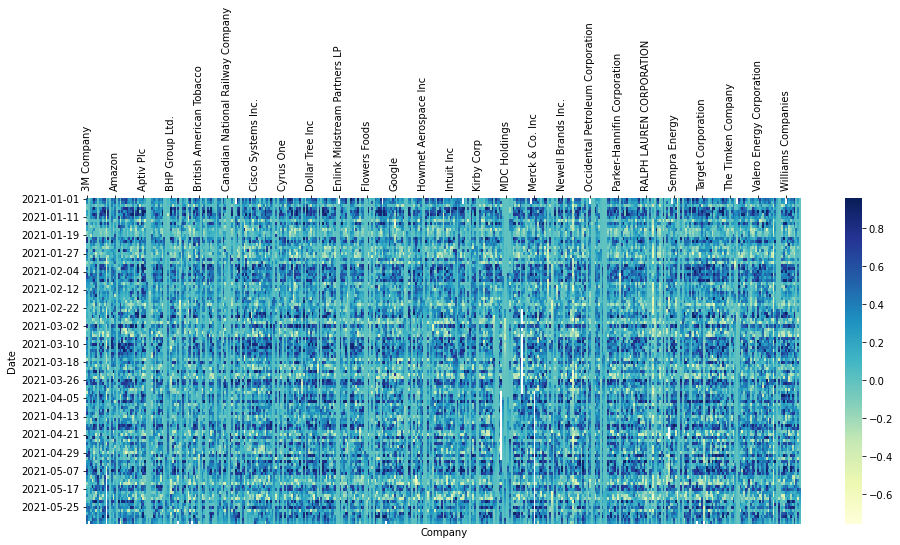

In [7]:
dfsentiment2 = dfsentiment[['Date', 'Company', 'Average']]
dfsentiment2 = dfsentiment2[~(dfsentiment2['Date'] < '2021-01-01')]

dfsentiment2['Date'] = pd.to_datetime(dfsentiment2['Date'], utc=True).dt.date 
dfsentiment2 = pd.pivot_table(dfsentiment2, index=["Date"],columns="Company",values="Average")
ax = sn.heatmap(dfsentiment2, cmap="YlGnBu")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(16, 6)

## Correlations and Accuracy  <a class="anchor" id="correlations"></a>
[ToC](#contents)

In [8]:
correlations = dfsentiment.corr().unstack().sort_values(ascending=False) # Build correlation matrix
correlations = pd.DataFrame(correlations).reset_index() # Convert to dataframe
correlations.columns = ['Return', 'Method', 'Correlation with Returns'] # Label it
result2 = correlations.query("Return == 'Return' & Method != 'Return'") # Filter by variable
result2 = result2.drop(['Return'], axis = 1)

result2

,Method,Correlation with Returns
25,Average,0.014952
27,FinBERT,0.013149
29,LMD,0.012645
31,VADER,0.007725
33,HIV4,0.003444


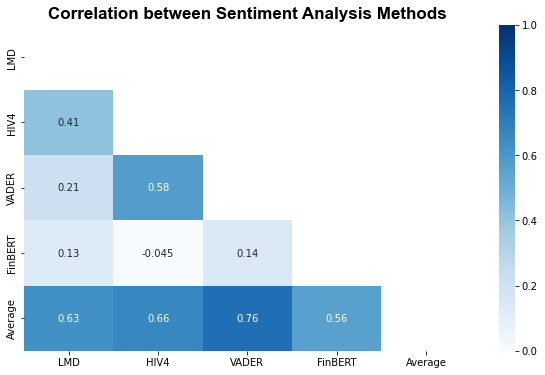

In [9]:
dfMethodCorrelation = pd.DataFrame(dfsentiment,columns=['LMD','HIV4','VADER', 'FinBERT', 'Average'])
corrMatrixPearson = dfMethodCorrelation.corr()
mask = np.triu(corrMatrixPearson)
sn.heatmap(corrMatrixPearson, annot=True, vmin=0, vmax=1, cmap="Blues", mask=mask)
plt.title("Correlation between Sentiment Analysis Methods", fontname="arial", fontsize=17, fontweight="bold")
fig = plt.gcf()
fig.set_size_inches(10, 6)

## 10% Portfolio  <a class="anchor" id="10"></a>
[ToC](#contents)

In [10]:
list_methods = ['LMD','HIV4','VADER', 'FinBERT', 'Average']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.1 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.1 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [11]:
newportfolio10 = pd.DataFrame(dict_ret).transpose()
newportfolio10 = newportfolio10.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'VADER', 3: 'FinBERT', 4:'Average'})
newportfolio10.to_csv('10percentportfolio.csv')

<AxesSubplot:title={'center':'MSTD(30) Returns of Long-Short (10%) Portfolio'}, xlabel='Date', ylabel='MSTD Returns (%)'>

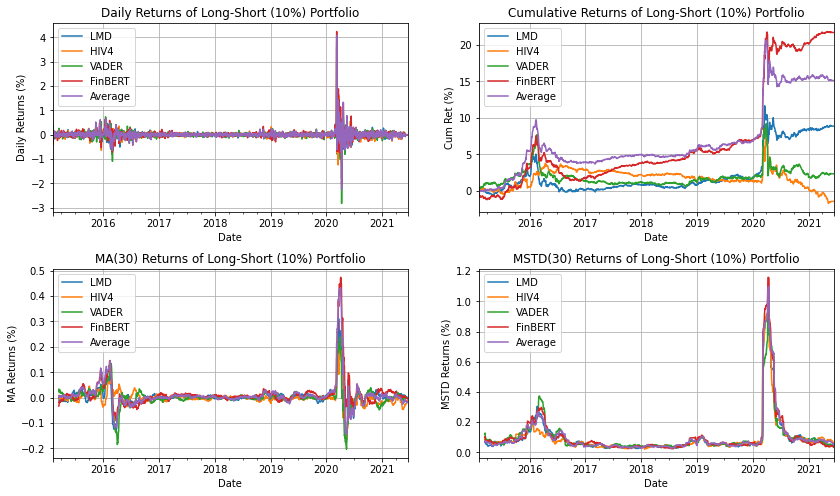

In [12]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.3)
newportfolio10.plot(ax=ax1, title='Daily Returns of Long-Short (10%) Portfolio', xlabel='Date', ylabel='Daily Returns (%)', grid=True)
newportfolio10.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (10%) Portfolio', xlabel='Date', ylabel='Cum Ret (%)', grid=True)
newportfolio10.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (10%) Portfolio', xlabel='Date', ylabel='MA Returns (%)', grid=True)
newportfolio10.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (10%) Portfolio', xlabel='Date', ylabel='MSTD Returns (%)', grid=True)

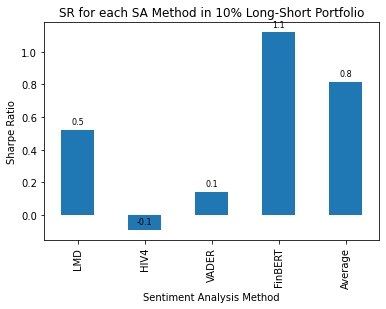

In [13]:
newportfolio10 = pd.read_csv('10percentportfolio.csv')
newportfolio10 = newportfolio10.rename(columns={'Unnamed: 0': 'Date'})
# newportfolio10 = newportfolio10[~(newportfolio10['Date'] < '2019-01-01')]
methodreturn = newportfolio10[['LMD','HIV4','VADER', 'FinBERT', 'Average']]

mean_return = methodreturn.mean()
std_return = methodreturn.std()
businessDays = 262
annual_factor = np.sqrt(businessDays)
SR = (mean_return*annual_factor)/(std_return)

plots = SR.plot.bar(title='SR for each SA Method in 10% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

## 20% Porfolio  <a class="anchor" id="20"></a>
[ToC](#contents)

In [14]:
list_methods = ['LMD','HIV4','VADER', 'FinBERT', 'Average']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.2 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.2 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [15]:
newportfolio20 = pd.DataFrame(dict_ret).transpose()
newportfolio20 = newportfolio20.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'VADER', 3: 'FinBERT', 4:'Average'})
newportfolio20.to_csv('20percentportfolio.csv')

<AxesSubplot:title={'center':'MSTD(30) Returns of Long-Short (20%) Portfolio'}, xlabel='Date', ylabel='MSTD Returns (%)'>

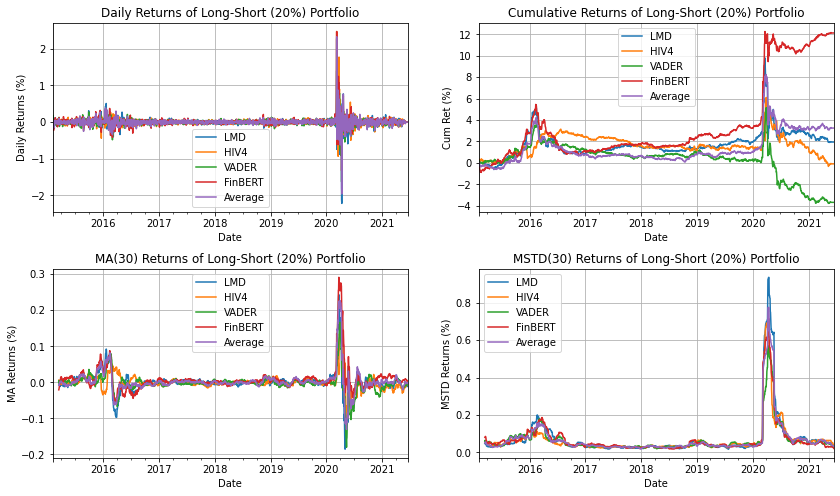

In [16]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.3)
newportfolio20.plot(ax=ax1, title='Daily Returns of Long-Short (20%) Portfolio', xlabel='Date', ylabel='Daily Returns (%)', grid=True)
newportfolio20.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (20%) Portfolio', xlabel='Date', ylabel='Cum Ret (%)', grid=True)
newportfolio20.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (20%) Portfolio', xlabel='Date', ylabel='MA Returns (%)', grid=True)
newportfolio20.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (20%) Portfolio', xlabel='Date', ylabel='MSTD Returns (%)', grid=True)

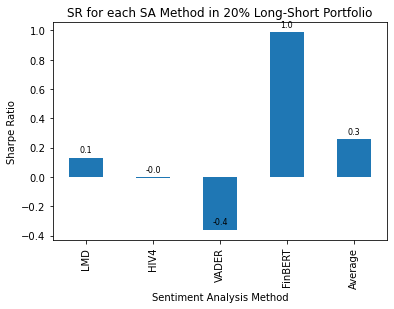

In [17]:
newportfolio20 = pd.read_csv('20percentportfolio.csv')
newportfolio20 = newportfolio20.rename(columns={'Unnamed: 0': 'Date'})
methodreturn = newportfolio20[['LMD','HIV4','VADER', 'FinBERT', 'Average']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())

plots = SR.plot.bar(title='SR for each SA Method in 20% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

## 50% Portfolio  <a class="anchor" id="50"></a>
[ToC](#contents)

In [18]:
list_methods = ['LMD','HIV4','VADER', 'FinBERT', 'Average']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.5 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.5 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [19]:
newportfolio50 = pd.DataFrame(dict_ret).transpose()
newportfolio50 = newportfolio50.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'VADER', 3: 'FinBERT', 4:'Average'})
newportfolio50.to_csv('50percentportfolio.csv')

<AxesSubplot:title={'center':'MSTD(30) Returns of Long-Short (50%) Portfolio'}, xlabel='Date', ylabel='MSTD Returns (%)'>

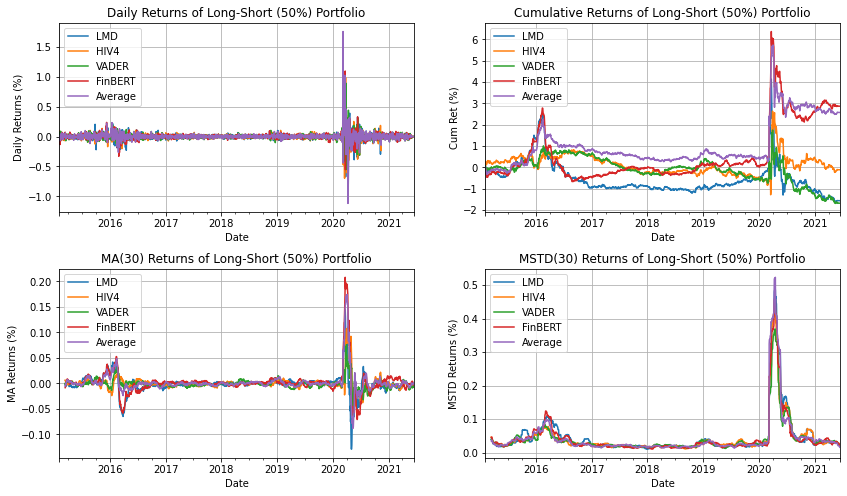

In [20]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.3)
newportfolio50.plot(ax=ax1, title='Daily Returns of Long-Short (50%) Portfolio', xlabel='Date', ylabel='Daily Returns (%)', grid=True)
newportfolio50.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (50%) Portfolio', xlabel='Date', ylabel='Cum Ret (%)', grid=True)
newportfolio50.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (50%) Portfolio', xlabel='Date', ylabel='MA Returns (%)', grid=True)
newportfolio50.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (50%) Portfolio', xlabel='Date', ylabel='MSTD Returns (%)', grid=True)

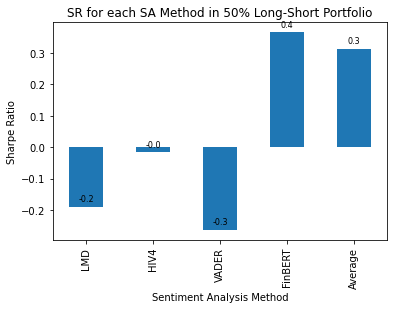

In [21]:
newportfolio50 = pd.read_csv('50percentportfolio.csv')
newportfolio50 = newportfolio50.rename(columns={'Unnamed: 0': 'Date'})
methodreturn = newportfolio50[['LMD','HIV4','VADER', 'FinBERT', 'Average']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())

plots = SR.plot.bar(title='SR for each SA Method in 50% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

### LMD, Half-Life 4 days: Different Day Lags

In [204]:
# Read in Dataframes
dfsentimentReuters = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment Reuters.csv')
dfsentimentMW = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment MW.csv')
dfsentimentTMF = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment TMF.csv')
dfsentimentFrames = [dfsentimentReuters, dfsentimentMW, dfsentimentTMF]
dfsentiment = pd.concat(dfsentimentFrames)
dfsentiment = dfsentiment.groupby(['Date','Company']).mean().reset_index()
dfticker = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Company Ticker.csv')
dfreturns = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Returns.csv')

# Change datetime
dfsentiment['Date'] = pd.to_datetime(dfsentiment['Date'])
dfsentiment = dfsentiment.drop(['Unnamed: 0'], axis = 1)

df0, df1, df2, df3, df4 = pd.DataFrame(), pd.DataFrame(),pd.DataFrame(), pd.DataFrame(),pd.DataFrame()
df0, df1, df2, df3, df4 = dfsentiment.copy(), dfsentiment.copy(), dfsentiment.copy(), dfsentiment.copy(), dfsentiment.copy()

df1['Date'] = df1['Date'] + 2*BusinessDay()
df2['Date'] = df2['Date'] + 3*BusinessDay()
df3['Date'] = df3['Date'] + 4*BusinessDay()
df4['Date'] = df4['Date'] + 5*BusinessDay()


dfreturns['Date'] = pd.to_datetime(dfreturns['prd'].astype(str), format='%Y%m%d')
lst = pd.bdate_range(start = '2015-02-03', end = '2021-06-16').tolist()

# Drop redundant columns
dfticker = dfticker.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
dfreturns = dfreturns.drop(['Unnamed: 0', 'prd'], axis = 1)
dfreturns = dfreturns[['Date', 'int_tick', 'tret']]

# Rename columns
dfticker = dfticker.rename(columns={'Company Name': 'Company'})
dfreturns = dfreturns.rename(columns={'int_tick': 'Ticker', 'tret': 'Return'})
dfsentiment = dfsentiment.rename(columns={'LMD_Polarity': 'LMD', 'HIV4_Polarity': 'HIV4', 'Vader_Polarity': 'VADER', 'FinBert_Polarity': 'FinBERT'})


# Map Tickers and Returns onto dfsentiment
df0 = df0.merge(dfticker, how='left').merge(dfreturns, how='left')
df1 = df1.merge(dfticker, how='left').merge(dfreturns, how='left')
df2 = df2.merge(dfticker, how='left').merge(dfreturns, how='left')
df3 = df3.merge(dfticker, how='left').merge(dfreturns, how='left')
df4 = df4.merge(dfticker, how='left').merge(dfreturns, how='left')

df0 = df0.rename(columns={'LMD_Polarity': '0'})
df1 = df1.rename(columns={'LMD_Polarity': '1'})
df2 = df2.rename(columns={'LMD_Polarity': '2'})
df3 = df3.rename(columns={'LMD_Polarity': '3'})
df4 = df4.rename(columns={'LMD_Polarity': '4'})

df0 = df0[['Date', 'Company', '0', 'Return', 'Ticker']]
df1 = df1[['Date', 'Company', '1', 'Return', 'Ticker']]
df2 = df2[['Date', 'Company', '2', 'Return', 'Ticker']]
df3 = df3[['Date', 'Company', '3', 'Return', 'Ticker']]
df4 = df4[['Date', 'Company', '4', 'Return', 'Ticker']]

dfsentiment = df0.merge(df1, how='left').merge(df2, how='left').merge(df3, how='left').merge(df4, how='left')
dfsentiment = dfsentiment[['Date', 'Company','Ticker', '0','1','2','3','4', 'Return']]

In [205]:
companies = dfticker['Company'].to_list()
list_methods = ['0', '1', '2','3','4']

all_df = []

for company in companies:
    df = dfsentiment.loc[dfsentiment['Company'] == company]
    
    for i in range(0,len(list_methods)):
        s = df[list_methods[i]].ffill()
        df[list_methods[i]]=df[list_methods[i]].fillna(s[df[list_methods[i]].isnull()].mul((1/(2**(1/4)))**(df[list_methods[i]].groupby(df[list_methods[i]].notnull().cumsum()).cumcount()),0))
    all_df.append(df)
    
    
dfsentiment = pd.concat(all_df, ignore_index=True)

<ipython-input-205-b61a7d2436b5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[list_methods[i]]=df[list_methods[i]].fillna(s[df[list_methods[i]].isnull()].mul((1/(2**(1/4)))**(df[list_methods[i]].groupby(df[list_methods[i]].notnull().cumsum()).cumcount()),0))


In [206]:
## ROLLING AVERAGE OF 2 DAYS (YDAY, TODAY)
correlations = dfsentiment.corr().unstack().sort_values(ascending=False) # Build correlation matrix
correlations = pd.DataFrame(correlations).reset_index() # Convert to dataframe
correlations.columns = ['Return', 'Method', 'Correlation with Returns'] # Label it
result2 = correlations.query("Return == 'Return' & Method != 'Return'") # Filter by variable
result2 = result2.drop(['Return'], axis = 1)

print("LMD - Returns correlation:     ", dfsentiment['0'].corr(dfsentiment['Return']))
print("HIV4 - Returns correlation:    ", dfsentiment['1'].corr(dfsentiment['Return']))
print("VADER - Returns correlation:   ", dfsentiment['2'].corr(dfsentiment['Return']))
print("FinBERT - Returns correlation: ", dfsentiment['3'].corr(dfsentiment['Return']))
print("Average - Returns correlation: ", dfsentiment['4'].corr(dfsentiment['Return']))


# print("Roll 2D - Returns correlation: ", dfsentiment['Rolling2'].corr(dfsentiment['Return']))

result2

LMD - Returns correlation:      0.012611339874642238
HIV4 - Returns correlation:     0.007657895883491327
VADER - Returns correlation:    0.0062168244898039935
FinBERT - Returns correlation:  0.0022279528794232036
Average - Returns correlation:  0.000545695255892206


,Method,Correlation with Returns
27,0,0.012611
29,1,0.007658
30,2,0.006217
32,3,0.002228
34,4,0.000546


In [207]:
list_methods = ['0','1','2', '3', '4']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna()
        total_return = 0
        total_count = 0

        if len(sample_df.dropna()) >= 20:
            large_df = sample_df.nlargest(int(0.2 * len(sample_df)), list_methods[x])
            small_df = sample_df.nsmallest(int(0.2 * len(sample_df)), list_methods[x])
            
            total_ret_long = 0
            count_long = 0 
            for j in range(0, len(large_df)):

                company = large_df.iloc[j]['Company']
                ticker = large_df.iloc[j]['Ticker']
                ret = large_df.iloc[j]['Return']
                count_long = count_long + 1
                total_ret_long = total_ret_long + ret

            total_ret_short = 0 
            count_short = 0
            for k in range(0, len(small_df)):
                company = small_df.iloc[k]['Company']
                ticker = large_df.iloc[j]['Ticker']
                ret = large_df.iloc[j]['Return']
                count_short = count_short + 1
                total_ret_short = total_ret_short + ret

            if count_long > 0: 
                total_ret_long = total_ret_long / count_long 

            if count_short > 0:
                total_ret_short = total_ret_short / count_short

            total_return = 100 * (total_ret_long - total_ret_short)
            dict_ret[x][lst[i]] = total_return

In [208]:
decayportfolio20 = pd.DataFrame(dict_ret).transpose()
decayportfolio20 = decayportfolio20.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4:'4'})
decayportfolio20.std()
decayportfolio20.to_csv('decayportfolio20.csv')

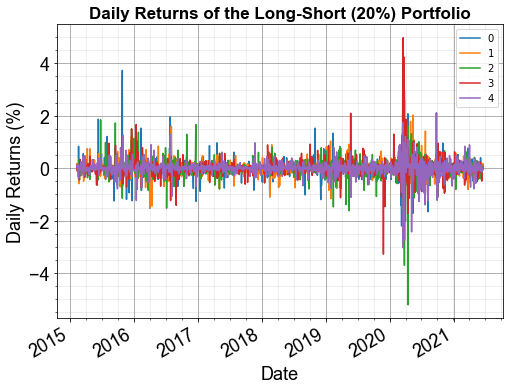

In [209]:
decayportfolio20.plot()
plt.title('Daily Returns of the Long-Short (20%) Portfolio', fontname="arial", fontsize=17, fontweight="bold")
plt.xlabel('Date', fontname="arial", fontsize=18)
plt.ylabel('Daily Returns (%)', fontname="arial", fontsize=18)
plt.xticks(fontname="arial", fontsize=18)
plt.yticks(fontname="arial", fontsize=18)

plt.grid(which='major', linestyle='-', linewidth='0.5', color='#666666')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set_matplotlib_formats('svg')
fig = plt.gcf()
fig.set_size_inches(8, 6)
# plt.savefig('6_1_5.pdf')

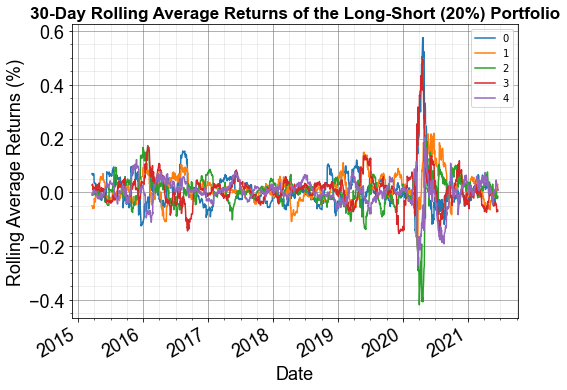

In [210]:
decayportfolio20.rolling(30).mean().plot()
plt.title('30-Day Rolling Average Returns of the Long-Short (20%) Portfolio', fontname="arial", fontsize=17, fontweight="bold")
plt.xlabel('Date', fontname="arial", fontsize=18)
plt.ylabel('Rolling Average Returns (%)', fontname="arial", fontsize=18)
plt.xticks(fontname="arial", fontsize=18)
plt.yticks(fontname="arial", fontsize=18)

plt.grid(which='major', linestyle='-', linewidth='0.5', color='#666666')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set_matplotlib_formats('svg')
fig = plt.gcf()
fig.set_size_inches(8, 6)
# plt.savefig('6_1_6.pdf')

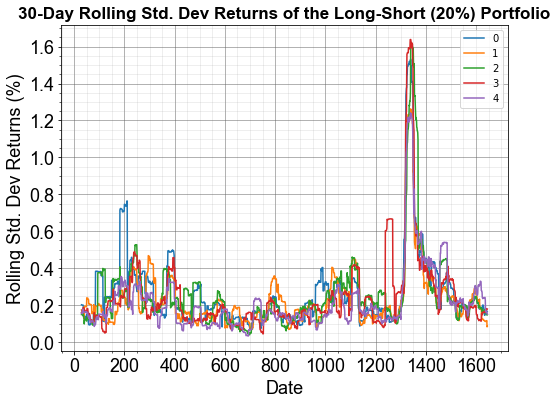

In [212]:
decayportfolio20.rolling(30).std().plot()
plt.title('30-Day Rolling Std. Dev Returns of the Long-Short (20%) Portfolio', fontname="arial", fontsize=17, fontweight="bold")
plt.xlabel('Date', fontname="arial", fontsize=18)
plt.ylabel('Rolling Std. Dev Returns (%)', fontname="arial", fontsize=18)
plt.xticks(fontname="arial", fontsize=18)
plt.yticks(fontname="arial", fontsize=18)

plt.grid(which='major', linestyle='-', linewidth='0.5', color='#666666')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set_matplotlib_formats('svg')
fig = plt.gcf()
fig.set_size_inches(8, 6)
# plt.savefig('6_1_7.pdf')

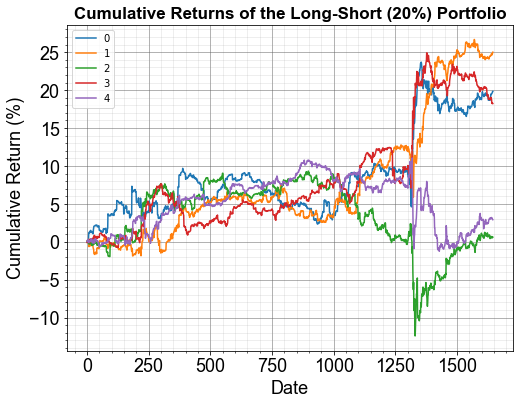

In [213]:
decayportfolio20.cumsum().plot()
plt.title('Cumulative Returns of the Long-Short (20%) Portfolio', fontname="arial", fontsize=17, fontweight="bold")
plt.xlabel('Date', fontname="arial", fontsize=18)
plt.ylabel('Cumulative Return (%)', fontname="arial", fontsize=18)
plt.xticks(fontname="arial", fontsize=18)
plt.yticks(fontname="arial", fontsize=18)

plt.grid(which='major', linestyle='-', linewidth='0.5', color='#666666')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set_matplotlib_formats('svg')
fig = plt.gcf()
fig.set_size_inches(8, 6)
# plt.savefig('6_1_8.pdf')

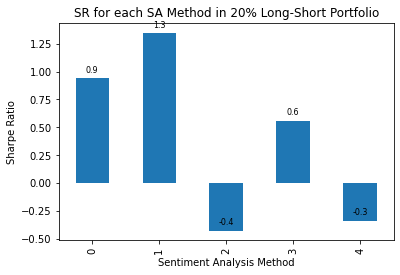

In [34]:
decayportfolio20 = pd.read_csv('decayportfolio20.csv')
decayportfolio20 = decayportfolio20.rename(columns={'Unnamed: 0': 'Date'})
decayportfolio20 = decayportfolio20[~(decayportfolio20['Date'] < '2019-01-03')]
# decayportfolio20 = decayportfolio20[~(decayportfolio20['Date'] > '2021-02-03')]
methodreturn = decayportfolio20[['0','1','2', '3', '4']]
lengthPortfolio = len(methodreturn)

mean_return = methodreturn.mean()
std_return = methodreturn.std()
businessDays = 252
annual_factor = np.sqrt(businessDays)
SR = (mean_return*businessDays**.5)/(std_return)

plots = SR.plot.bar(title='SR for each SA Method in 20% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

### FinBERT, Half-Life 4 days: Different Day Lags

In [259]:
# Read in Dataframes
dfsentimentReuters = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment Reuters.csv')
dfsentimentMW = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment MW.csv')
dfsentimentTMF = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment TMF.csv')
dfsentimentFrames = [dfsentimentReuters, dfsentimentMW, dfsentimentTMF]
dfsentiment = pd.concat(dfsentimentFrames)
dfsentiment = dfsentiment.groupby(['Date','Company']).mean().reset_index()
dfticker = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Company Ticker.csv')
dfreturns = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Returns.csv')

# Change datetime
dfsentiment['Date'] = pd.to_datetime(dfsentiment['Date'])
dfsentiment = dfsentiment.drop(['Unnamed: 0'], axis = 1)

df0, df1, df2, df3, df4 = pd.DataFrame(), pd.DataFrame(),pd.DataFrame(), pd.DataFrame(),pd.DataFrame()
df0, df1, df2, df3, df4 = dfsentiment.copy(), dfsentiment.copy(), dfsentiment.copy(), dfsentiment.copy(), dfsentiment.copy()

df1['Date'] = df1['Date'] + timedelta(days=1)
df2['Date'] = df2['Date'] + timedelta(days=2)
df3['Date'] = df3['Date'] + timedelta(days=3)
df4['Date'] = df4['Date'] + timedelta(days=4)


dfreturns['Date'] = pd.to_datetime(dfreturns['prd'].astype(str), format='%Y%m%d')
lst = pd.bdate_range(start = '2015-02-03', end = '2021-06-16').tolist()

# Drop redundant columns
dfticker = dfticker.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
dfreturns = dfreturns.drop(['Unnamed: 0', 'prd'], axis = 1)
dfreturns = dfreturns[['Date', 'int_tick', 'tret']]

# Rename columns
dfticker = dfticker.rename(columns={'Company Name': 'Company'})
dfreturns = dfreturns.rename(columns={'int_tick': 'Ticker', 'tret': 'Return'})
dfsentiment = dfsentiment.rename(columns={'LMD_Polarity': 'LMD', 'HIV4_Polarity': 'HIV4', 'Vader_Polarity': 'VADER', 'FinBert_Polarity': 'FinBERT'})


# Map Tickers and Returns onto dfsentiment
df0 = df0.merge(dfticker, how='left').merge(dfreturns, how='left')
df1 = df1.merge(dfticker, how='left').merge(dfreturns, how='left')
df2 = df2.merge(dfticker, how='left').merge(dfreturns, how='left')
df3 = df3.merge(dfticker, how='left').merge(dfreturns, how='left')
df4 = df4.merge(dfticker, how='left').merge(dfreturns, how='left')

df0 = df0.rename(columns={'FinBert_Polarity': '0'})
df1 = df1.rename(columns={'FinBert_Polarity': '1'})
df2 = df2.rename(columns={'FinBert_Polarity': '2'})
df3 = df3.rename(columns={'FinBert_Polarity': '3'})
df4 = df4.rename(columns={'FinBert_Polarity': '4'})

df0 = df0[['Date', 'Company', '0', 'Return', 'Ticker']]
df1 = df1[['Date', 'Company', '1', 'Return', 'Ticker']]
df2 = df2[['Date', 'Company', '2', 'Return', 'Ticker']]
df3 = df3[['Date', 'Company', '3', 'Return', 'Ticker']]
df4 = df4[['Date', 'Company', '4', 'Return', 'Ticker']]

dfsentiment = df0.merge(df1, how='left').merge(df2, how='left').merge(df3, how='left').merge(df4, how='left')
dfsentiment = dfsentiment[['Date', 'Company','Ticker', '0','1','2','3','4', 'Return']]

In [260]:
companies = dfticker['Company'].to_list()
list_methods = ['0', '1', '2','3','4']

all_df = []

for company in companies:
    df = dfsentiment.loc[dfsentiment['Company'] == company]
    
    for i in range(0,len(list_methods)):
        s = df[list_methods[i]].ffill()
        df[list_methods[i]]=df[list_methods[i]].fillna(s[df[list_methods[i]].isnull()].mul((1/(2**(1/4)))**(df[list_methods[i]].groupby(df[list_methods[i]].notnull().cumsum()).cumcount()),0))
    all_df.append(df)
    
    
dfsentiment = pd.concat(all_df, ignore_index=True)

<ipython-input-260-b61a7d2436b5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[list_methods[i]]=df[list_methods[i]].fillna(s[df[list_methods[i]].isnull()].mul((1/(2**(1/4)))**(df[list_methods[i]].groupby(df[list_methods[i]].notnull().cumsum()).cumcount()),0))


In [261]:
list_methods = ['0','1','2', '3', '4']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna()
        total_return = 0
        total_count = 0

        if len(sample_df.dropna()) >= 20:
            large_df = sample_df.nlargest(int(0.2 * len(sample_df)), list_methods[x])
            small_df = sample_df.nsmallest(int(0.2 * len(sample_df)), list_methods[x])
            
            total_ret_long = 0
            count_long = 0 
            for j in range(0, len(large_df)):

                company = large_df.iloc[j]['Company']
                ticker = large_df.iloc[j]['Ticker']
                ret = large_df.iloc[j]['Return']
                count_long = count_long + 1
                total_ret_long = total_ret_long + ret

            total_ret_short = 0 
            count_short = 0
            for k in range(0, len(small_df)):
                company = small_df.iloc[k]['Company']
                ticker = large_df.iloc[j]['Ticker']
                ret = large_df.iloc[j]['Return']
                count_short = count_short + 1
                total_ret_short = total_ret_short + ret

            if count_long > 0: 
                total_ret_long = total_ret_long / count_long 

            if count_short > 0:
                total_ret_short = total_ret_short / count_short

            total_return = 100 * (total_ret_long - total_ret_short)
            dict_ret[x][lst[i]] = total_return

In [262]:
FBdecayportfolio20 = pd.DataFrame(dict_ret).transpose()
FBdecayportfolio20 = FBdecayportfolio20.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4:'4'})
FBdecayportfolio20.std()
FBdecayportfolio20.to_csv('FBdecayportfolio20.csv')

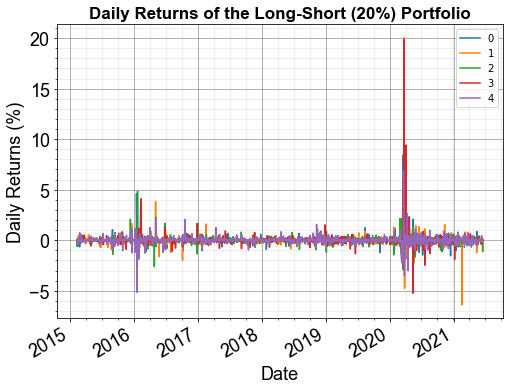

In [263]:
FBdecayportfolio20.plot()
plt.title('Daily Returns of the Long-Short (20%) Portfolio', fontname="arial", fontsize=17, fontweight="bold")
plt.xlabel('Date', fontname="arial", fontsize=18)
plt.ylabel('Daily Returns (%)', fontname="arial", fontsize=18)
plt.xticks(fontname="arial", fontsize=18)
plt.yticks(fontname="arial", fontsize=18)

plt.grid(which='major', linestyle='-', linewidth='0.5', color='#666666')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set_matplotlib_formats('svg')
fig = plt.gcf()
fig.set_size_inches(8, 6)
# plt.savefig('6_1_5.pdf')

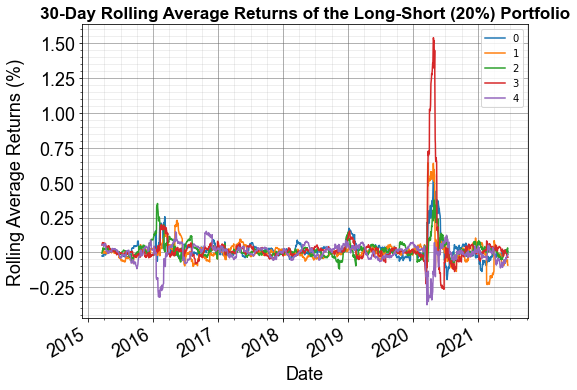

In [264]:
FBdecayportfolio20.rolling(30).mean().plot()
plt.title('30-Day Rolling Average Returns of the Long-Short (20%) Portfolio', fontname="arial", fontsize=17, fontweight="bold")
plt.xlabel('Date', fontname="arial", fontsize=18)
plt.ylabel('Rolling Average Returns (%)', fontname="arial", fontsize=18)
plt.xticks(fontname="arial", fontsize=18)
plt.yticks(fontname="arial", fontsize=18)

plt.grid(which='major', linestyle='-', linewidth='0.5', color='#666666')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set_matplotlib_formats('svg')
fig = plt.gcf()
fig.set_size_inches(8, 6)
# plt.savefig('6_1_6.pdf')

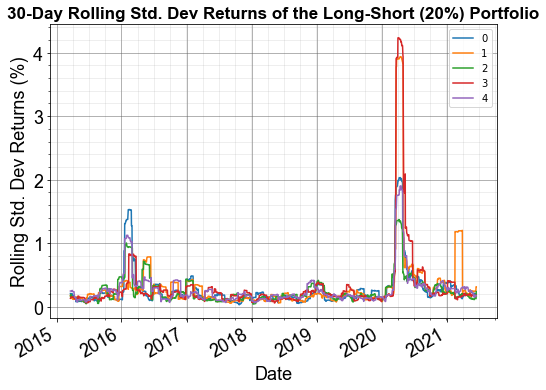

In [265]:
FBdecayportfolio20.rolling(30).std().plot()
plt.title('30-Day Rolling Std. Dev Returns of the Long-Short (20%) Portfolio', fontname="arial", fontsize=17, fontweight="bold")
plt.xlabel('Date', fontname="arial", fontsize=18)
plt.ylabel('Rolling Std. Dev Returns (%)', fontname="arial", fontsize=18)
plt.xticks(fontname="arial", fontsize=18)
plt.yticks(fontname="arial", fontsize=18)

plt.grid(which='major', linestyle='-', linewidth='0.5', color='#666666')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set_matplotlib_formats('svg')
fig = plt.gcf()
fig.set_size_inches(8, 6)
# plt.savefig('6_1_7.pdf')

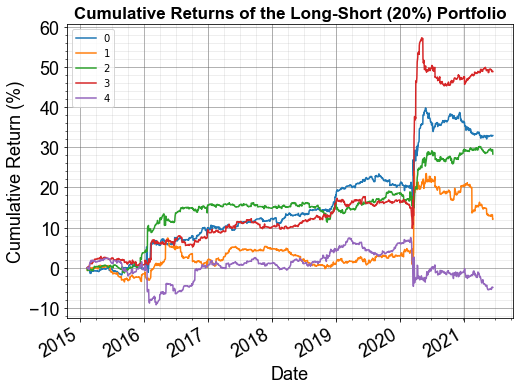

In [266]:
FBdecayportfolio20.cumsum().plot()
plt.title('Cumulative Returns of the Long-Short (20%) Portfolio', fontname="arial", fontsize=17, fontweight="bold")
plt.xlabel('Date', fontname="arial", fontsize=18)
plt.ylabel('Cumulative Return (%)', fontname="arial", fontsize=18)
plt.xticks(fontname="arial", fontsize=18)
plt.yticks(fontname="arial", fontsize=18)

plt.grid(which='major', linestyle='-', linewidth='0.5', color='#666666')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set_matplotlib_formats('svg')
fig = plt.gcf()
fig.set_size_inches(8, 6)
# plt.savefig('6_1_8.pdf')

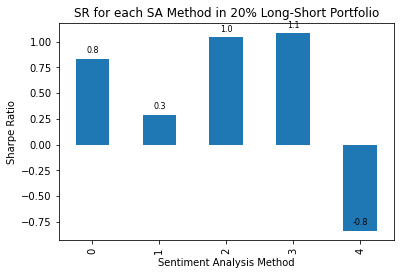

In [58]:
FBdecayportfolio20 = pd.read_csv('FBdecayportfolio20.csv')
FBdecayportfolio20 = FBdecayportfolio20.rename(columns={'Unnamed: 0': 'Date'})
FBdecayportfolio20 = FBdecayportfolio20[~(FBdecayportfolio20['Date'] < '2020-02-03')]
# FBdecayportfolio20 = FBdecayportfolio20[~(FBdecayportfolio20['Date'] > '2016-02-03')]
methodreturn = FBdecayportfolio20[['0','1','2', '3', '4']]

cov_return = methodreturn.cov()
mean_return = methodreturn.mean()
std_return = methodreturn.std()
SR = (mean_return*(252**.5))/(std_return)

plots = SR.plot.bar(title='SR for each SA Method in 20% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

In [285]:
# Read in Dataframes
dfsentimentReuters = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment Reuters.csv')
dfsentimentMW = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment MW.csv')
dfsentimentTMF = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Merged Sentiment TMF.csv')
dfsentimentFrames = [dfsentimentReuters, dfsentimentMW, dfsentimentTMF]
dfsentiment = pd.concat(dfsentimentFrames)
dfsentiment = dfsentiment.groupby(['Date','Company']).mean().reset_index()
dfticker = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Company Ticker.csv')
dfreturns = pd.read_csv(r'/Users/mayagolan/OneDrive - Imperial College London/EE4/FYP/Final-Year-Project-main/Returns.csv')

# Change datetime
dfsentiment['Date'] = pd.to_datetime(dfsentiment['Date'])
# dfsentiment['Date'] += timedelta(days=1)
dfreturns['Date'] = pd.to_datetime(dfreturns['prd'].astype(str), format='%Y%m%d')
lst = pd.bdate_range(start = '2015-02-03', end = '2021-06-16').tolist()

# Drop redundant columns
dfticker = dfticker.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
dfreturns = dfreturns.drop(['Unnamed: 0', 'prd'], axis = 1)
dfreturns = dfreturns[['Date', 'int_tick', 'tret']]
dfsentiment = dfsentiment.drop(['Unnamed: 0'], axis = 1)

# Rename columns
dfticker = dfticker.rename(columns={'Company Name': 'Company'})
dfreturns = dfreturns.rename(columns={'int_tick': 'Ticker', 'tret': 'Return'})
dfsentiment = dfsentiment.rename(columns={'LMD_Polarity': 'LMD', 'HIV4_Polarity': 'HIV4', 'Vader_Polarity': 'VADER', 'FinBert_Polarity': 'FinBERT'})

In [286]:
companies = dfticker['Company'].to_list()
list_methods = ['LMD', 'HIV4', 'VADER','FinBERT']
all_df = []

for company in companies:
    df = dfsentiment.loc[dfsentiment['Company'] == company]
    
    for i in range(0,len(list_methods)):
        s = df[list_methods[i]].ffill()
        df[list_methods[i]]=df[list_methods[i]].fillna(s[df[list_methods[i]].isnull()].mul((1/(2**(1/4)))**(df[list_methods[i]].groupby(df[list_methods[i]].notnull().cumsum()).cumcount()),0))
    all_df.append(df)
    
dfsentiment = pd.concat(all_df, ignore_index=True)

<ipython-input-286-a813443c59e3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[list_methods[i]]=df[list_methods[i]].fillna(s[df[list_methods[i]].isnull()].mul((1/(2**(1/4)))**(df[list_methods[i]].groupby(df[list_methods[i]].notnull().cumsum()).cumcount()),0))


In [313]:
companies = dfticker['Company'].to_list()
all_df = []

for company in companies:
    df = dfsentiment.loc[dfsentiment['Company'] == company]
    df = df.dropna()
    df['Rolling2']=df['LMD'].rolling(2).mean()
    all_df.append(df)
    
dfsentiment = pd.concat(all_df, ignore_index=True)

In [314]:
# Map Tickers and Returns onto dfsentiment
dfsentiment = dfsentiment.merge(dfticker, how='left').merge(dfreturns, how='left')

# Calculate Average Sentiment and Rolling mean (yday + today)
dfsentiment['Average'] = dfsentiment[['LMD', 'FinBERT', 'VADER', 'HIV4']].mean(axis=1).dropna()
# dfsentiment['Rolling2'] = dfsentiment['Average'].rolling(2).mean()
# dfsentiment['Rolling30'] = dfsentiment['Average'].rolling(30).mean()
dfsentiment = dfsentiment[['Date', 'Company', 'Ticker', 'LMD', 'HIV4', 'VADER', 'FinBERT','Average', 'Rolling2', 'Return']]

# Remove weekends and companies not in Investable Universe
# dfsentiment = dfsentiment[dfsentiment['Date'].dt.weekday < 5] # Remove weekends
no_return_list = list(dfsentiment[dfsentiment['Ticker'].isna()]['Company'].unique()) # Remove companies not in IU
dfsentiment = dfsentiment[~dfsentiment['Company'].isin(no_return_list)]

In [315]:
print("Unique Dates: ", dfsentiment['Date'].nunique())
print("Unique Companies: ", dfsentiment['Company'].nunique())
print("Unique Tickers: ", dfsentiment['Ticker'].nunique())
dfsentiment.dropna()

Unique Dates:  1650
Unique Companies:  414
Unique Tickers:  414


,Date,Company,Ticker,LMD,HIV4,VADER,FinBERT,Average,Rolling2,Return
1,2015-02-06,3M Company,U_MMM,0.402168,0.385823,0.839635,0.799780,0.606852,0.440214,-0.000090
2,2015-02-09,3M Company,U_MMM,0.239130,0.229412,0.499250,0.475552,0.360836,0.320649,-0.000060
3,2015-02-10,3M Company,U_MMM,0.201084,0.192912,0.419818,0.399890,0.303426,0.220107,-0.000140
4,2015-02-11,3M Company,U_MMM,0.169091,0.162219,0.353023,0.336266,0.255150,0.185087,-0.000050
5,2015-02-12,3M Company,U_MMM,0.142188,0.136409,0.296856,0.282765,0.214554,0.155639,-0.000120
...,...,...,...,...,...,...,...,...,...,...
1130569,2021-06-10,eBay,U_EBAY,1.000000,0.692308,0.822500,0.840822,0.838907,0.750000,0.000511
1130570,2021-06-11,eBay,U_EBAY,1.000000,0.692308,0.888500,-0.840138,0.435167,1.000000,0.000461
1130571,2021-06-14,eBay,U_EBAY,0.200000,0.454545,0.612400,-0.959861,0.076771,0.600000,0.000361
1130572,2021-06-15,eBay,U_EBAY,1.000000,0.272727,0.571900,-0.968259,0.219092,0.600000,-0.000110


In [316]:
correlations = dfsentiment.corr().unstack().sort_values(ascending=False) # Build correlation matrix
correlations = pd.DataFrame(correlations).reset_index() # Convert to dataframe
correlations.columns = ['Return', 'Method', 'Correlation with Returns'] # Label it
result2 = correlations.query("Return == 'Return' & Method != 'Return'") # Filter by variable
result2 = result2.drop(['Return'], axis = 1)

print("LMD - Returns correlation:     ", dfsentiment['LMD'].corr(dfsentiment['Return']))
print("HIV4 - Returns correlation:    ", dfsentiment['HIV4'].corr(dfsentiment['Return']))
print("VADER - Returns correlation:   ", dfsentiment['VADER'].corr(dfsentiment['Return']))
print("FinBERT - Returns correlation: ", dfsentiment['FinBERT'].corr(dfsentiment['Return']))
print("Average - Returns correlation: ", dfsentiment['Average'].corr(dfsentiment['Return']))
print("Rolling2 - Returns correlation: ", dfsentiment['Rolling2'].corr(dfsentiment['Return']))

print("Roll 2D - Returns correlation: ", dfsentiment['Rolling2'].corr(dfsentiment['Return']))

result2

LMD - Returns correlation:      0.012611339874642212
HIV4 - Returns correlation:     0.003943761286043396
VADER - Returns correlation:    0.010243245549581535
FinBERT - Returns correlation:  0.015018713258307233
Average - Returns correlation:  0.016491287326662933
Rolling2 - Returns correlation:  0.010832901870497161


,Method,Correlation with Returns
36,Average,0.016491
37,FinBERT,0.015019
40,LMD,0.012611
41,Rolling2,0.010833
43,VADER,0.010243
46,HIV4,0.003944


<AxesSubplot:>

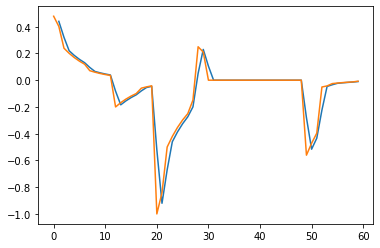

In [324]:
dfsentiment['Rolling2'].head(60).plot.line()
dfsentiment['LMD'].head(60).plot.line()

<AxesSubplot:>

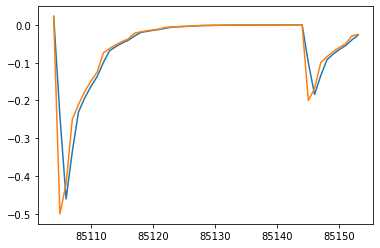

In [330]:
df2 = dfsentiment.loc[dfsentiment['Company'] == 'Apple']
df2['Rolling2'].iloc[400:450].plot.line()
df2['LMD'].iloc[400:450].plot.line()